# Régression logistique avec descente de gradient et calcul parallèle

In [48]:
library(readxl)
library(ggplot2)
library(devtools)
library(formula.tools)
library(parallel)

In [26]:
# test avec data_breast_cancer
data <- read_excel("breast.xlsx")

In [27]:
str(data)

tibble [699 x 10] (S3: tbl_df/tbl/data.frame)
 $ clump     : num [1:699] 10 4 1 2 4 1 1 5 3 1 ...
 $ ucellsize : num [1:699] 6 2 1 1 1 1 1 1 1 1 ...
 $ ucellshape: num [1:699] 6 2 1 1 1 1 1 1 1 1 ...
 $ mgadhesion: num [1:699] 2 1 1 1 1 1 1 1 1 1 ...
 $ sepics    : num [1:699] 4 2 2 2 2 2 2 2 2 2 ...
 $ bnuclei   : num [1:699] 10 1 1 1 1 1 1 1 1 4 ...
 $ bchromatin: num [1:699] 9 2 2 2 2 1 2 2 2 2 ...
 $ normnucl  : num [1:699] 7 1 1 1 1 1 1 1 1 1 ...
 $ mitoses   : num [1:699] 1 1 1 1 1 1 1 1 1 1 ...
 $ classe    : chr [1:699] "malignant" "begnin" "begnin" "begnin" ...


In [28]:
# Conversion de la variable en 0/1 à intégrer dans une fonction ?

data$classe <- as.factor(data$classe)
levels(data$classe) <- c(0, 1)
data$classe <- as.numeric(levels(data$classe))[data$classe]
# y <- matrix(ifelse(data_frame[, 1] == "malignant", 1, 0))

In [29]:
data

clump,ucellsize,ucellshape,mgadhesion,sepics,bnuclei,bchromatin,normnucl,mitoses,classe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,6,6,2,4,10,9,7,1,1
4,2,2,1,2,1,2,1,1,0
1,1,1,1,2,1,2,1,1,0
2,1,1,1,2,1,2,1,1,0
4,1,1,1,2,1,2,1,1,0
1,1,1,1,2,1,1,1,1,0
1,1,1,1,2,1,2,1,1,0
5,1,1,1,2,1,2,1,1,0
3,1,1,1,2,1,2,1,1,0


In [30]:
get_x_y <- function(formula, data) {
    data_frame <- model.frame(formula, data)

    # y <- as.factor(data_frame[, 1])
    # levels(y) <- c(1, 0)
    # y <- matrix(as.integer(y))


    # y <- matrix(ifelse(data_frame[, 1] == "malignant", 1, 0))

    y <- as.matrix(data_frame[, 1])


    x <- data_frame[, -1]
    x <- as.matrix(data.frame(rep(1, length(y)), x))

    return(list(target = y, features = x))
}

## Fonction sigmoide

$ \Large h(x) =  \frac{1}{1 + e^{-x} }  $  

![equation](https://latex.codecogs.com/png.latex?%5Clarge%20h%28x%29%20%3D%20%5Cfrac%7B1%7D%7B1%20&plus;%20e%5E%7B-x%7D%20%7D)

In [31]:
sigmoid <- function(x) {
    return(1 / (1 + exp(-x)))
}

## Modèle

$ \Large F(X) = X.\theta  $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20F%28X%29%20%3D%20X.%5Ctheta)

In [32]:
x_dot_theta <- function(x, theta) {
    return(x %*% theta)
}

## Fonction de la régression logistique

$ \Large h_ \theta (x) =  \frac{1}{1 + e^{- X.\theta} }  $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20h_%20%5Ctheta%20%28x%29%20%3D%20%5Cfrac%7B1%7D%7B1%20&plus;%20e%5E%7B-%20X.%5Ctheta%7D%20%7D)

In [33]:
probability <- function(x, theta) {
    return(sigmoid(x_dot_theta(x, theta))) # nolint
}

## Fonction de cout

$ \Large J(\theta) = -\frac{1}{m} \sum y \times log(\sigma(X.\theta)) + (1-y) \times (1-\sigma(X.\theta)) $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20J%28%5Ctheta%29%20%3D%20-%5Cfrac%7B1%7D%7Bm%7D%20%5Csum%20y%20%5Ctimes%20log%28%5Csigma%28X.%5Ctheta%29%29%20&plus;%20%281-y%29%20%5Ctimes%20%281-%5Csigma%28X.%5Ctheta%29%29)

In [34]:
cost_function <- function(x, y, theta) {
    m <- nrow(y)
    g <- probability(x, theta) # nolint
    j <- (1 / m) * sum((-y * log(g)) - ((1 - y) * log(1 - g)))
    return(j)
}

## Calcul du gradient

$\Large \frac{\partial J(\theta) }{\partial \theta} = \frac{1}{m} X^T.(\sigma(X.\theta)-y)$  
![equation](https://latex.codecogs.com/gif.latex?%5Cfrac%7B%5Cpartial%20J%28%5Ctheta%29%20%7D%7B%5Cpartial%20%5Ctheta%7D%20%3D%20%5Cfrac%7B1%7D%7Bm%7D%20X%5ET.%28%5Csigma%28X.%5Ctheta%29-y%29)



In [35]:
# Gradient : calcul des dérivées partielles de chacun des paramètres de theta
gradient <- function(x, y, theta) {
    m <- nrow(y)
    return((1 / m) * x_dot_theta(t(x), probability(x, theta) - y)) # nolint
}

## Descente de gradient

$\Large \theta = \theta - \alpha \frac{\partial J(\theta) }{\partial \theta}$  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20%5Ctheta%20%3D%20%5Ctheta%20-%20%5Calpha%20%5Cfrac%7B%5Cpartial%20J%28%5Ctheta%29%20%7D%7B%5Cpartial%20%5Ctheta%7D)




In [36]:
batch_gradient_descent <- function(X, theta, learning_rate, n_iter) {
    
    x <- X[[1]]
    y <- X[[2]]

    cost_history <- c(cost_function(x, y, theta)) # nolint
    m <- nrow(y)

    for (i in 1:n_iter) {
        # Shuffle data
        random_index <- sample(x = m, size = m)
        # Update theta
        theta <- theta - learning_rate * gradient(x[random_index, ], as.matrix(y[random_index, ]), theta) # nolint
        cost_history <- c(cost_history, cost_function(x, y, theta)) # nolint
    }
    return(list(theta = theta, cost_history = cost_history))
}

In [37]:
stochastic_gradient_descent <- function(X, theta, learning_rate, n_iter) {
    x <- X[[1]]
    y <- X[[2]]
    
    cost_history <- c(cost_function(x, y, theta)) # nolint
    m <- nrow(y)
    random_index <- sample(x = m, size = m)
    for (i in 1:n_iter) {
        # Shuffle data
        random_index <- sample(x = m, size = m)
        for (j in 1:m) {
            # Update theta
            y_i <- as.matrix(y[random_index[j], ])
            x_i <- t(as.matrix(x[random_index[j], ]))
            theta <- theta - learning_rate * gradient(x_i, y_i, theta) # nolint
            cost_history <- c(cost_history, cost_function(x, y, theta)) # nolint
        }
    }
    return(list(theta = theta, cost_history = cost_history))
}

In [38]:
mini_batch_gradient_descent <- function(X, theta, learning_rate, n_iter, batch_size) {

    x <- X[[1]]
    y <- X[[2]]
    
    cost_history <- c(cost_function(x, y, theta))
    m <- nrow(y)

    for (i in 1:n_iter) {
        # Shuffle data
        random_index <- sample(x = m, size = m)
        x <- as.matrix(x[random_index, ])
        y <- as.matrix(y[random_index, ])
        x_i <- c()
        y_i <- c()

        index <- seq(1, m, batch_size - 1)

        for (j in 1:trunc(m / batch_size)) {
            y_i <- as.matrix(y[index[[j]]:index[[j + 1]], ])
            x_i <- as.matrix(x[index[[j]]:index[[j + 1]], ])
            theta <- theta - learning_rate * gradient(x_i, y_i, theta)
            cost_history <- c(cost_history, cost_function(x, y, theta))
        }
    }
    return(list(theta = theta, cost_history = cost_history))
}

In [52]:
parallelisation <- function(x, y, ncores, fonction, theta, learning_rate, n_iter){
    #Création des blocs
    m <- nrow(y)
    blocs_size <- trunc((m / ncores))
    blocs <- list()
    index <- seq(1, m, blocs_size - 1)
    for (j in 1:trunc(m / blocs_size)) {
        y_i <- as.matrix(y[index[[j]]:index[[j + 1]], ])
        x_i <- as.matrix(x[index[[j]]:index[[j + 1]], ])
        blocs[[j]] <- list(x_i, y_i)
    }

    #Parallel
    clust <- parallel::makeCluster(ncores)
    clusterExport(clust, c("gradient" ,"x_dot_theta" ,"sigmoid" ,"probability" , "cost_function", "get_x_y"), # nolint
                envir=environment())

    res <- parallel::parSapply(clust, X = blocs, FUN = fonction, theta = theta, learning_rate = learning_rate, n_iter = n_iter) # nolint
    parallel::stopCluster(clust)
return(res)
}

In [112]:
moyenne <- function(gradient_descent){

    theta <- c()
    
    for (j in 1:(dim(gradient_descent[1,1]$theta)[1])){ #error
        temp <- 0
        for (i in 1:(dim(gradient_descent)[2])) {
            temp <- temp + (gradient_descent[1,i]$theta[j])
    }
        moy <- temp/(dim(gradient_descent)[2])
        theta <- rbind(theta,moy)
    }       

    ###cost_history
    cost_history <- c()

    for (j in 1:(length(gradient_descent[2,1]$cost_history)[1])){
        maxi <- 0
        for (i in 1:(dim(gradient_descent)[2])) {
            maxi <- max(gradient_descent[2,i]$cost_history[j])
        }
        cost_history <- rbind(cost_history,maxi)
    }
    return(list(theta = theta, cost_history = cost_history))
}

In [50]:
# Gradient descent
fit <- function(formula, data, mode, batch_size, learning_rate, n_iter, ncores) { # nolint

    x_y <- get_x_y(formula, data) # nolint
    
    x <- x_y$features
    y <- x_y$target
    initial_theta <- as.matrix(rnorm(n = dim(x)[2], mean = 0, sd = 1))




    if (mode == "batch" || (mode == "mini-batch" && batch_size >= nrow(y))) {
 
        gradient_descent <- parallelisation (x, y, ncores, batch_gradient_descent, initial_theta, learning_rate, n_iter) # nolint

    } else if (mode == "stochastic" || (mode == "mini-batch" && batch_size == 1)) { # nolint

        gradient_descent <- parallelisation (x, y, ncores, stochastic_gradient_descent, initial_theta, learning_rate, n_iter) # nolint

    } else if (mode == "mini-batch") {

        gradient_descent <- parallelisation (x, y, ncores, mini_batch_gradient_descent, initial_theta, learning_rate, n_iter) # nolint

    } else {

        return("erreur")

    }

    gradient_descent <- moyenne(gradient_descent)
    # Création de l'instance
    inst <- list(formula = formula, x = x, y = y, mode = mode, batch_size = batch_size, learning_rate = learning_rate, n_iter = n_iter, # nolint
        initial_theta = initial_theta, theta = gradient_descent[[1]], cost_history = gradient_descent[[2]], ncores=ncores) # nolint

    attr(inst, "class") <- "Reg.Log"
    return(inst)
}

In [42]:
# Surchage de la fonction print pour l'objet retourné par fit
print.Reg.Log <- function(obj) { # nolint
    cat("Model:", as.character(obj$formula), "\n")
    cat("Mode:", obj$mode, "\n")
    cat("Learning rate:", obj$learning_rate, "\n")
    cat("n_iter:", obj$n_iter, "\n")
    cat("Batch size:", obj$batch_size, "\n")
    cat("Coefficient:", obj$theta, "\n")
    cat("Cost history:", obj$cost_history)
}

In [113]:
# Print de l'objet de la classe fit
obj.Reg.Log <- fit(classe ~ ., data, mode = "batch", batch_size = 32, learning_rate = 0.1, n_iter = 4,ncores = 3) # nolint
print(obj.Reg.Log)

Model: classe ~ . 
Mode: batch 
Learning rate: 0.1 
n_iter: 4 
Batch size: 32 
Coefficient: 1.749993 2.792689 0.3067741 -1.324186 -0.6491916 -1.979598 -0.08564103 0.9828306 -0.2103935 -0.8767296 
Cost history: 4.412022 4.255741 4.10344 3.953414 3.80531

In [90]:
obj.Reg.Log$theta

moy,0.132165600
moy,-1.570276781
moy,0.117456622
moy,-1.264502109
moy,0.046362804
moy,0.918569000
moy,-0.024278455
moy,1.809180427
moy,1.044526134
moy,0.004200043


In [ ]:
# Comparaison de print de glm
obj <- glm(classe ~ clump + ucellsize, data = data, family = "binomial")
print(obj)


Call:  glm(formula = classe ~ clump + ucellsize, family = "binomial", 
    data = data)

Coefficients:
(Intercept)        clump    ucellsize  
    -7.1517       0.6174       1.1751  

Degrees of Freedom: 698 Total (i.e. Null);  696 Residual
Null Deviance:	    900.5 
Residual Deviance: 212.3 	AIC: 218.3


In [ ]:
# Surcharge de la fonction summary pour l'objet retourné par fit
summary.Reg.Log <- function(obj) {
    cat("Model:", as.character(obj$formula), "\n")
    cat("Mode:", obj$mode, "\n")
    cat("Learning rate:", obj$learning_rate, "\n")
    cat("n_iter:", obj$n_iter, "\n")
    cat("Batch size:", obj$batch_size, "\n")
    cat("Coefficient:", obj$theta, "\n")
    cat("Cost history:", obj$cost_history)
}

In [ ]:
# Comparaison de summary de glm
obj <- glm(classe ~ clump + ucellsize, data = data, family = "binomial")
summary(obj)


Call:
glm(formula = classe ~ clump + ucellsize, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7760  -0.2431  -0.0969   0.0303   2.6596  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.15170    0.60084 -11.903  < 2e-16 ***
clump        0.61739    0.09229   6.690 2.24e-11 ***
ucellsize    1.17507    0.12309   9.547  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 900.53  on 698  degrees of freedom
Residual deviance: 212.31  on 696  degrees of freedom
AIC: 218.31

Number of Fisher Scoring iterations: 7


In [ ]:
predict2 <- function(Reg.log, newdata, type) {

    # New data control
    
    # Probability of belonging
    probs = probability(newdata, Reg.Log$theta)

    if (type == "classe") {
        return(unlist(ifelse(probs > 0.5, 1, 0)))
    }else if (type == "posterior") {
        return(probs)
    }

}

In [96]:
predict <- function(x, theta) {
    predictions <- ifelse(probability(x, theta) > 0.5, 1, 0)
    return(predictions)
}

In [91]:
# Courbe parfois inversée ??? -> Cout initial négatif qui semble provoquer une

res1 <- fit(classe ~ ., data, mode = "batch", batch_size = 32, learning_rate = 0.01, n_iter = 500, ncore = 3)




In [100]:
length(res1$cost_history)

[1] 501

[1] 0.8597997


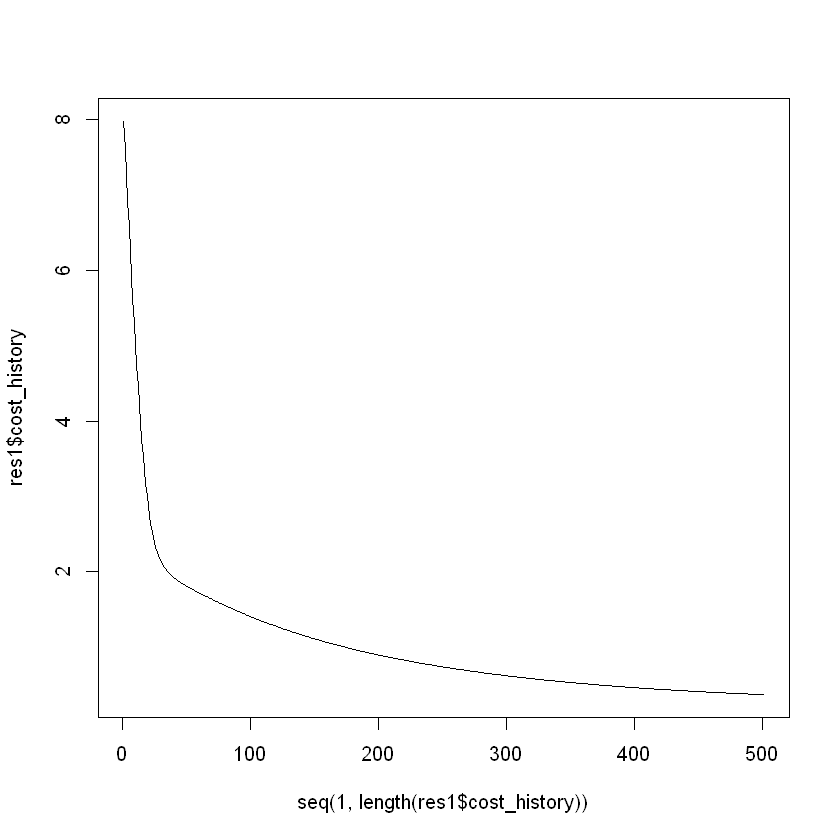

In [114]:
y_pred <- predict(res1$x, res1$theta)


plot(seq(1, length(res1$cost_history)), res1$cost_history, type = "l")

accuracy <- mean(y_pred == res1$y)
print(accuracy)

In [ ]:
predict_bis(res1,

                          [,1]
rep.1..length.y.. -3.368826014
clump             -0.003506896
ucellsize          0.542032968
ucellshape         0.182715904
mgadhesion         0.073933335
sepics            -0.372169639
bnuclei            0.471964817
bchromatin        -0.103366823
normnucl           0.253806909
mitoses            0.010842844
[1] 0.962804


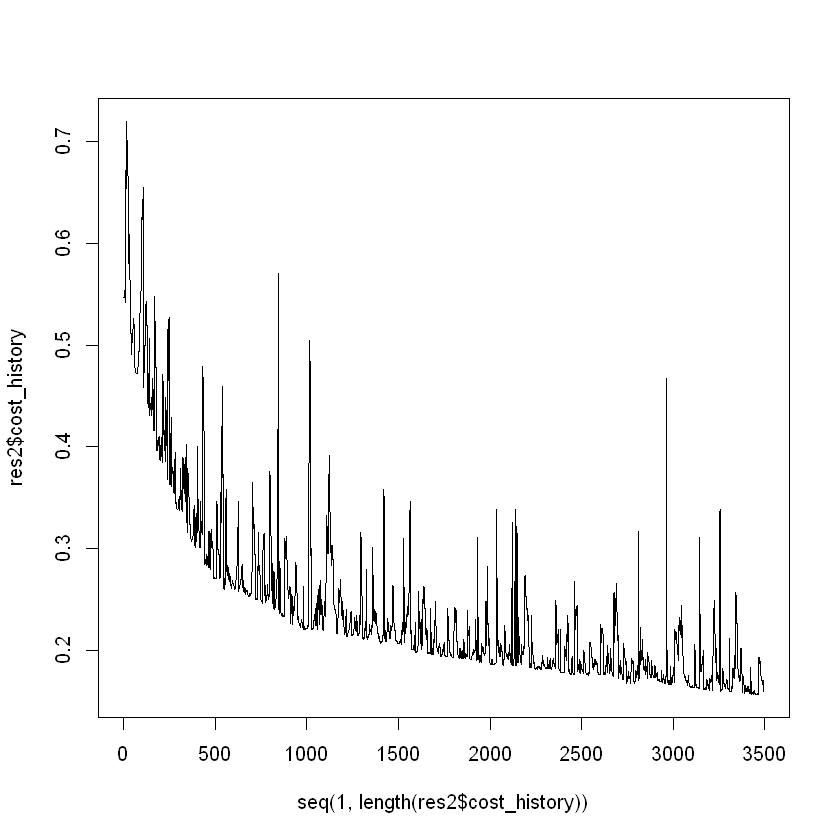

In [ ]:
res2 <- fit(classe ~ ., data, mode = "stochastic", batch_size = 32, learning_rate = 0.01, n_iter = 5)
y_pred <- predict(res2$x, res2$theta)
plot(seq(1, length(res2$cost_history)), res2$cost_history, type = "l")

print(res2$theta)

accuracy <- mean(y_pred == res2$y)
print(accuracy)

                         [,1]
rep.1..length.y..  1.44312259
clump             -0.61622946
ucellsize          2.62347639
ucellshape        -1.51469348
mgadhesion        -0.55663665
sepics            -0.06212571
bnuclei            0.88112785
bchromatin        -0.75964021
normnucl           0.80834667
mitoses           -1.25778846
[1] 0.702432


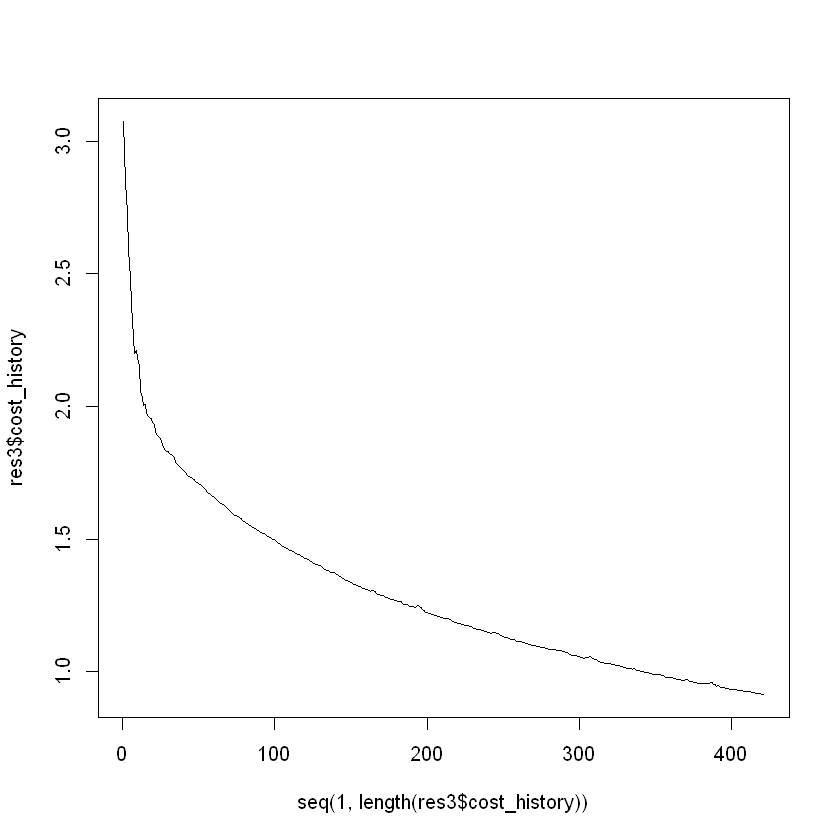

In [ ]:
res3 <- fit(classe ~ . , data, mode = "mini-batch", batch_size = 32, learning_rate = 0.01, n_iter = 20)
y_pred <- predict(res3$x, res3$theta)
plot(seq(1, length(res3$cost_history)), res3$cost_history, type = "l")

print(res3$theta)

accuracy <- mean(y_pred == res3$y)
print(accuracy)